In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import repack_fields
from numpy.lib.stride_tricks import as_strided


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

%matplotlib notebook

## Read Dataset

In [2]:
fname = 'GuangzhouPM20100101_20151231.csv'
usecols = np.array(['HUMI', 'PRES', 'Iws', 'Iprec', 'PM_US_Post'])
labels = np.array([0, 1, 2])
    
rec_raw = np.genfromtxt(fname,
                delimiter=',',
                names=True,
                dtype=np.float32,
                usecols=usecols,
                )

rec_raw.shape

(52584,)

## Covent Label

In [3]:
rec = rec_raw.copy()

rec['PM_US_Post'][rec['PM_US_Post'] < 10] = labels[0]
rec['PM_US_Post'][(rec['PM_US_Post'] <= 25) & (rec['PM_US_Post'] >= 10)] = labels[1]
rec['PM_US_Post'][rec['PM_US_Post'] > 25] = labels[2]

rec.shape

(52584,)

## Visualization

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:834: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:835: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


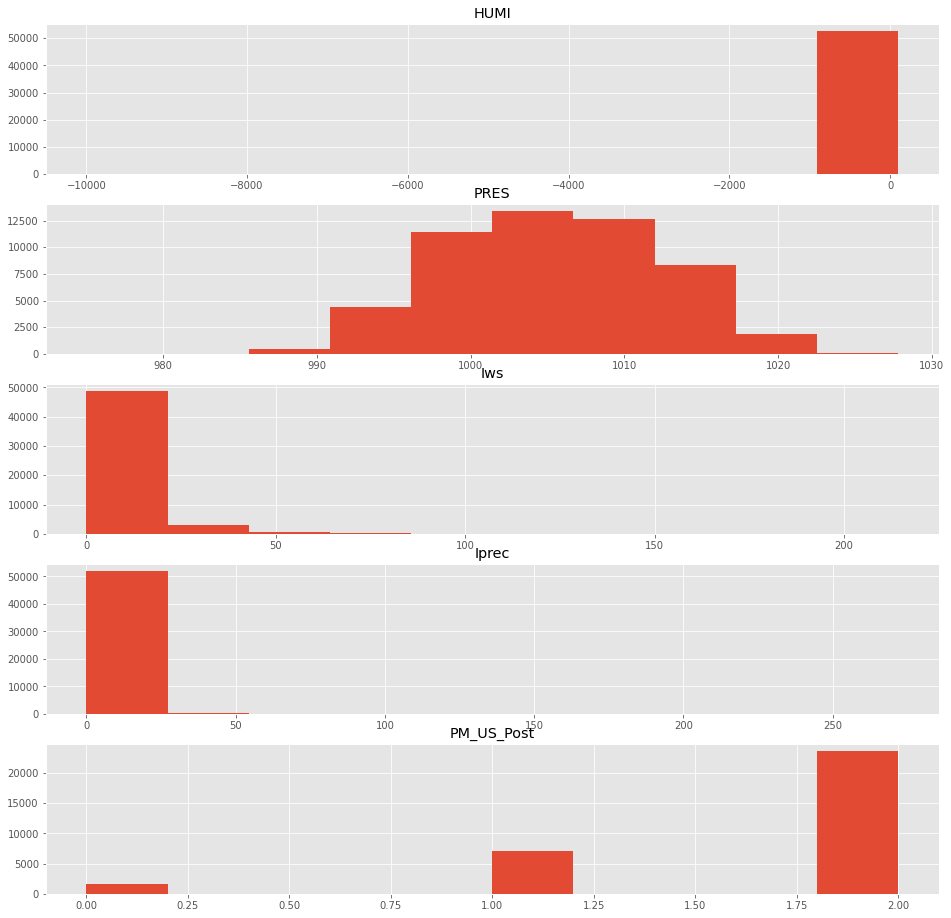

In [4]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

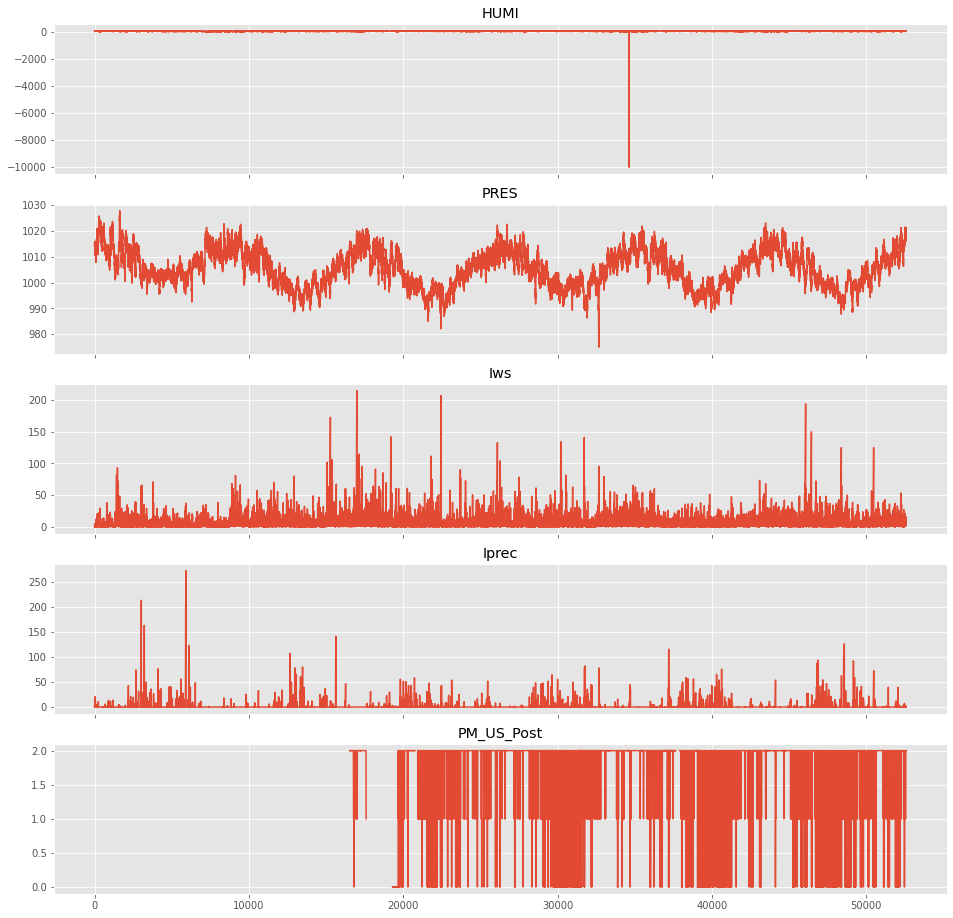

In [5]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [6]:
# import pandas as pd
# import seaborn as sns

# df = pd.DataFrame(rec)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)

## Drop Duplicate

In [7]:
rec = np.unique(rec, axis=0)

rec.shape

(52318,)

## Drop Label NaN

In [8]:
rec = rec[~np.isnan(rec['PM_US_Post'])]

rec.shape

(32086,)

## Count Label

In [9]:
unique, counts = np.unique(rec['PM_US_Post'], return_counts=True)

dict(zip(unique, counts))

{0.0: 1581, 1.0: 7067, 2.0: 23438}

## Show NaN row

In [10]:
view = rec.view(np.float32).reshape(-1, rec.dtype.__len__())

rec[np.any(np.isnan(view), axis=1)]

array([(nan, nan, nan, nan, 2.)],
      dtype=[('HUMI', '<f4'), ('PRES', '<f4'), ('Iws', '<f4'), ('Iprec', '<f4'), ('PM_US_Post', '<f4')])

## Interpolation

In [11]:
for i, col in enumerate(rec.dtype.names[:-1]):
    indices = np.arange(rec[col].shape[0])
    not_nan = ~np.isnan(rec[col])
    rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

## Moving Average

In [12]:
for i, col in enumerate(rec.dtype.names[:-1]):
    rec[col] = np.convolve(rec[col], np.ones(4)/4, mode='same')

## Visualization

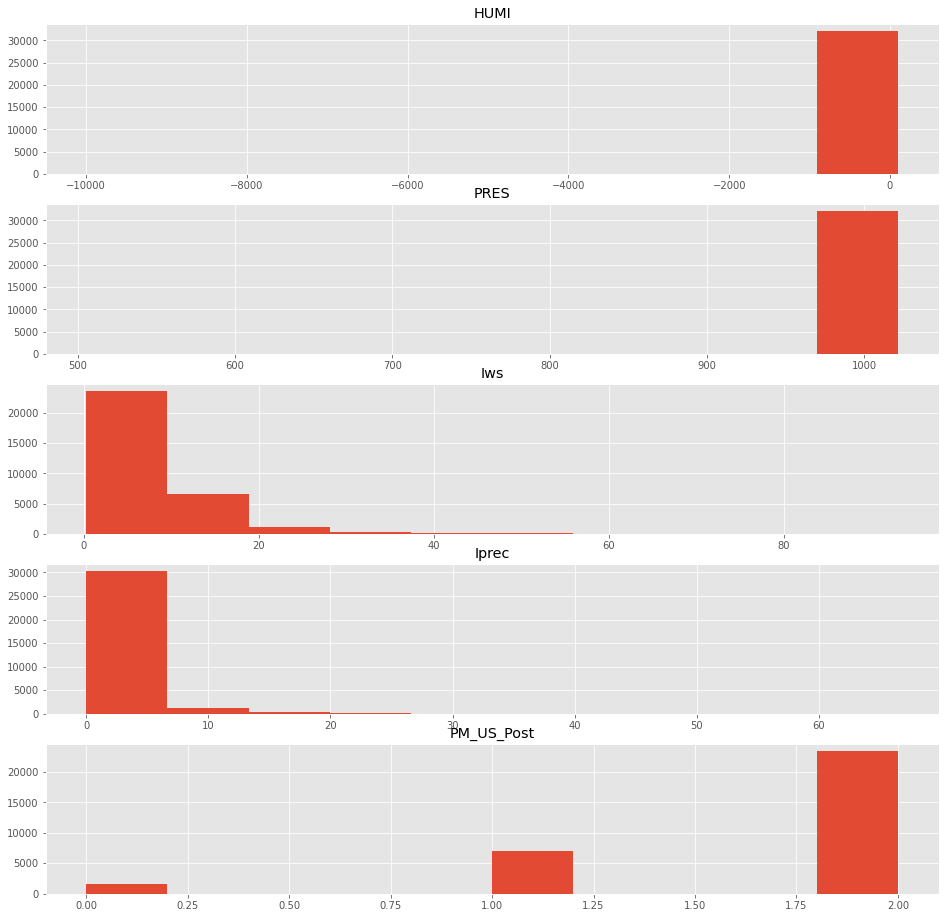

In [13]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

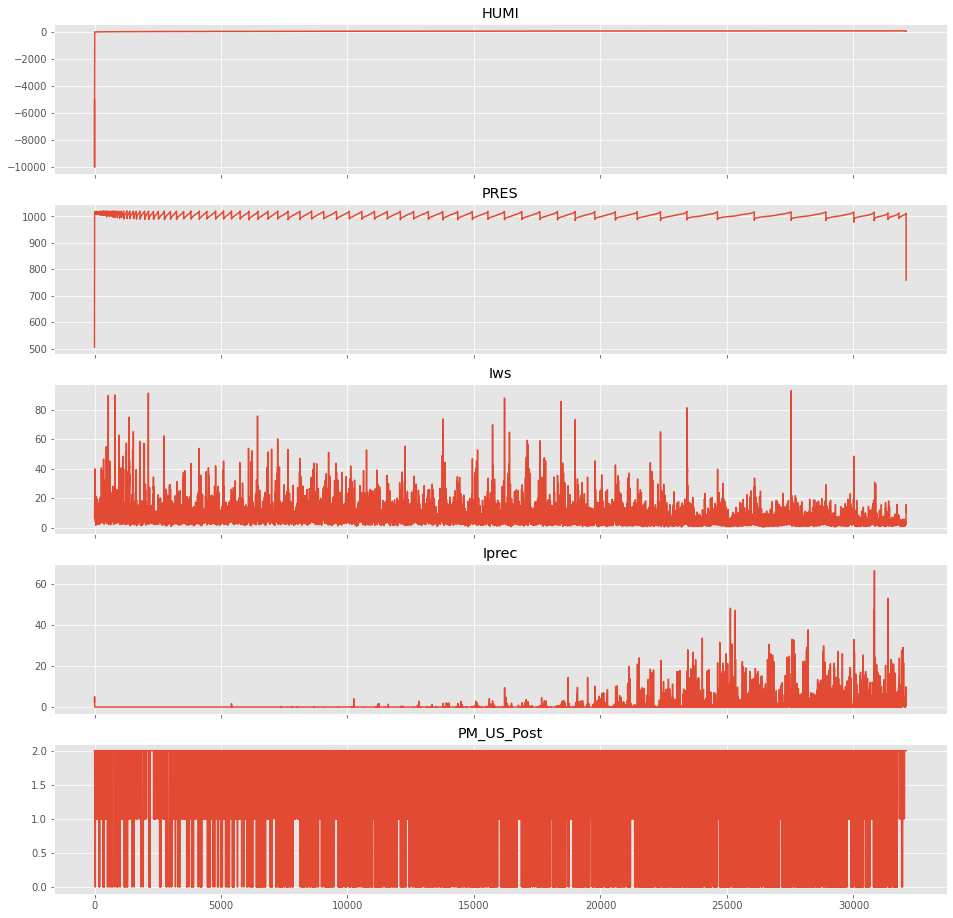

In [14]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [15]:
# df = pd.DataFrame(rec)
# g = sns.PairGrid(df)
# g.map_upper(plt.scatter)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.distplot)

## Standardization Normalization

In [16]:
for i, col in enumerate(rec.dtype.names[:-1]):
    rec[col] = (rec[col] - rec[col].mean()) / rec[col].std()


## Covent Time-series format

In [17]:
def create_strided(arr, step, windows):
    colsize = arr[0].__len__()
    itemsize = np.dtype(np.float32).itemsize
    shape = (arr.shape[0]//step, windows, colsize, 1)
    strides = (step*(colsize+1)*itemsize, colsize*itemsize, colsize*itemsize, itemsize)

    arr_windows = as_strided(arr, shape=shape, strides=strides)
    return arr_windows

In [18]:
step = 20
windows = 100

rec_windows = []
rec_labels = []
for label in labels:
    arr = repack_fields(rec[usecols[:-1]][rec['PM_US_Post'] == label]).view(np.float32).reshape(-1, usecols[:-1].__len__())
    j = create_strided(arr, step, windows)
    rec_windows.append(j)
    rec_labels.append(np.repeat(label, j.shape[0]))

rec_windows = np.concatenate(rec_windows)
rec_labels = np.concatenate(rec_labels)

rec.shape, rec_windows.shape, rec_labels.shape

((32086,), (1603, 100, 4, 1), (1603,))

## One-Hot Encoder

In [19]:
one_hot = np.zeros((rec_labels.shape[0], 1, labels.shape[0]))
for i, unique_value in enumerate(labels):
    one_hot[:, :, i][rec_labels == unique_value] = 1

rec_labels_onehot = one_hot.reshape(-1, labels.shape[0]*1)

rec_labels_onehot.shape

(1603, 3)

## Train & Test Split

In [20]:
random_state = 0

# np.random.seed(random_state)
# np.random.shuffle(rec_windows)

# np.random.seed(random_state)
# np.random.shuffle(rec_labels_onehot)

# rec_windows.shape, rec_labels_onehot.shape

In [21]:
train_size = 0.8
# Implement stratified samples
# sample = int(train_size*rec_labels_onehot.shape[0])

# X_train, X_test = rec_windows[:sample], rec_windows[sample:]
# y_train, y_test = rec_labels_onehot[:sample], rec_labels_onehot[sample:]

# X_train.shape, X_test.shape

In [22]:
X_4d_train, X_4d_test, y_train, y_test = train_test_split(rec_windows, rec_labels_onehot, test_size=1 -train_size, random_state=random_state, stratify=rec_labels_onehot)

X_3d_train = X_4d_train.reshape(-1, windows, usecols[:-1].__len__())
X_3d_test = X_4d_test.reshape(-1, windows, usecols[:-1].__len__())

X_4d_train.shape, X_4d_test.shape, y_train.shape, y_test.shape

((1282, 100, 4, 1), (321, 100, 4, 1), (1282, 3), (321, 3))

## CNN Model

In [23]:
def create_cnn(input_shape=X_4d_train.shape[1:], num_classes=y_train.shape[1],
               conv=(64, 128), conv_drop=(0.2, 0.2),
               kernel_size=(3, 3), pool_size=(2, 2), strides=(2, 2),
               dense=(256, 256), dense_dropout=(0.2, 0.2),
               activation='relu',
               lr=0.001, beta_1=0.9, beta_2=0.99):
    model = Sequential()

    model.add(Conv2D(conv[0], kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(conv_drop[0]))

    model.add(Conv2D(conv[1], kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(Dropout(conv_drop[1]))

    model.add(Flatten())

    model.add(Dense(dense[0], activation=activation))
    model.add(Dropout(dense_dropout[0]))

    model.add(Dense(dense[1], activation=activation))
    model.add(Dropout(dense_dropout[1]))

    model.add(Dense(num_classes, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
def create_lstm(input_shape=X_3d_train.shape[1:], num_classes=y_train.shape[1],
               dense=(64, 256), dense_dropout=(0.2, 0.2),
               activation='relu',
               lr=0.001, beta_1=0.9, beta_2=0.99):
    model = Sequential()

    model.add(LSTM(dense[0], activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout[0]))

    model.add(LSTM(dense[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dense_dropout[1]))

    model.add(Dense(num_classes, activation='sigmoid'))

    optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, amsgrad=False)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Summary

In [25]:
cnn = create_cnn()
cnn.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 4, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 4, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 2, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 2, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 2, 128)        73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 2, 128)        512       
____

In [26]:
lstm = create_lstm()
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           17664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 64)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [27]:
cnn_batch_size = 8
cnn_epochs = 8

cnn_history = cnn.fit(X_4d_train, y_train, batch_size=cnn_batch_size, epochs=cnn_epochs, validation_data=(X_4d_test, y_test))

Train on 1282 samples, validate on 321 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/8
1282/1282 [==============================] - 2s 2ms/sample - loss: 0.9160 - acc: 0.6638 - val_loss: 0.8413 - val_acc: 0.7290
Epoch 2/8
1282/1282 [==============================] - 1s 671us/sample - loss: 0.7270 - acc: 0.7309 - val_loss: 0.8105 - val_acc: 0.7290
Epoch 3/8
1282/1282 [==============================] - 1s 646us/sample - loss: 0.7336 - acc: 0.7309 - val_loss: 0.7151 - val_acc: 0.7290
Epoch 4/8
1282/1282 [==============================] - 1s 652us/sample - loss: 0.7217 - acc: 0.7309 - val_loss: 0.7447 - val_acc: 0.7290
Epoch 5/8
1282/1282 [==============================] - 1s 654us/sample - loss: 0.7177 - acc: 0.7309 - val_loss: 0.7145 - val_acc: 0.7290
Epoch 6/8
1282/1282 [==============================] - 1s 624us/sample - loss: 0.7216 - acc: 0.7309 - val_loss: 0.7182 - val_acc: 0.7290
Epoch 7/8
1282/1282 [==================

In [28]:
lstm_batch_size = 16
lstm_epochs = 2

lstm_history = lstm.fit(X_3d_train, y_train, batch_size=lstm_batch_size, epochs=lstm_epochs, validation_data=(X_3d_test, y_test))

Train on 1282 samples, validate on 321 samples
Epoch 1/2
1282/1282 [==============================] - 23s 18ms/sample - loss: 0.9406 - acc: 0.7090 - val_loss: 0.7840 - val_acc: 0.7290
Epoch 2/2
1282/1282 [==============================] - 22s 17ms/sample - loss: 0.7258 - acc: 0.7309 - val_loss: 0.7141 - val_acc: 0.7290


## Training accuracy and Training Loss Graph

Text(0, 0.5, 'Training loss')

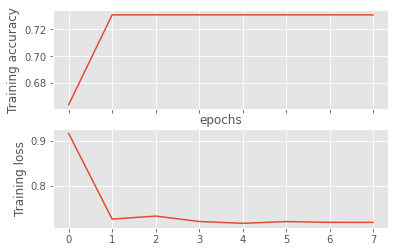

In [29]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(cnn_history.history['acc'], label=cnn)
ax[1].plot(cnn_history.history['loss'], label=cnn)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

Text(0, 0.5, 'Training loss')

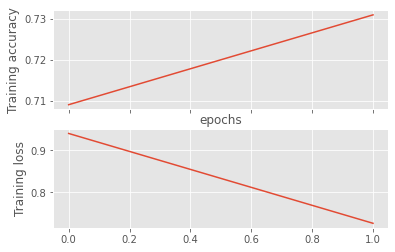

In [30]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(lstm_history.history['acc'], label=lstm)
ax[1].plot(lstm_history.history['loss'], label=lstm)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

## Evaluate

In [31]:
cnn_score = cnn.evaluate(X_4d_test, y_test)
lstm_score = lstm.evaluate(X_3d_test, y_test)

cnn_score, lstm_score

321/321 [==============================] - 1s 3ms/sample - loss: 0.7141 - acc: 0.7290


([0.716872353234395, 0.72897196], [0.7140831483116031, 0.72897196])

## Confusion Matrix

In [32]:
y_test_argmax = y_test.argmax(axis=1)
cnn_pred = cnn.predict_classes(X_4d_test)
lstm_pred = lstm.predict_classes(X_3d_test)

print('CNN')
print(classification_report(y_test_argmax, cnn_pred))
print('LSTM')
print(classification_report(y_test_argmax, lstm_pred))

CNN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        71
           2       0.73      1.00      0.84       234

    accuracy                           0.73       321
   macro avg       0.24      0.33      0.28       321
weighted avg       0.53      0.73      0.61       321

LSTM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        71
           2       0.73      1.00      0.84       234

    accuracy                           0.73       321
   macro avg       0.24      0.33      0.28       321
weighted avg       0.53      0.73      0.61       321



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification Report

In [33]:
print('CNN')
print(confusion_matrix(y_test_argmax, cnn_pred))
print('LSTM')
print(confusion_matrix(y_test_argmax, lstm_pred))

CNN
[[  0   0  16]
 [  0   0  71]
 [  0   0 234]]
LSTM
[[  0   0  16]
 [  0   0  71]
 [  0   0 234]]
